In [ ]:
!pip install transformers wandb datasets torchvision

In [2]:
from huggingface_hub import login
from google.colab import userdata
token = userdata.get('Nyi_token')
login(token=token)

import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face
!ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face
best_vitpose_model		   SegFormer_Huggingface_seg_train.ipynb
datasets			   segformer_trained_weights
markerpensseg			   segformer_trained_weights_47
Markerpens_seg			   ViT_Huggingface_classify.ipynb
mask2former_Huggingface_seg.ipynb  vit-multilabel-best
mask2formerresults		   ViTPose_Huggingface_keypoints.ipynb
mydrive				   YOLOS_Huggingface_det.ipynb
SegFormer_Huggingface_seg.ipynb    YOLOS_Huggingface_det_wandb.ipynb


In [5]:
import json
from pathlib import Path
from collections import defaultdict
from datasets import Dataset, DatasetDict
import shutil
import os
import random
from tqdm import tqdm

In [ ]:
def clean_coco_json(input_path, output_path):
    with open(input_path, "r") as f:
        data = json.load(f)

    # Remove category with id 0
    categories = [cat for cat in data["categories"] if cat["id"] != 0]
    valid_cat_ids = {cat["id"] for cat in categories}

    # Remove annotations with category_id 0
    annotations = [ann for ann in data["annotations"] if ann["category_id"] in valid_cat_ids]

    cleaned = {
        "images": data["images"],
        "annotations": annotations,
        "categories": categories,
        "licenses": data.get("licenses", []),
        "info": data.get("info", {})
    }

    with open(output_path, "w") as f:
        json.dump(cleaned, f)

# Run on your files
#clean_coco_json("datasets/sisdet/train.json", "datasets/sisdet/train_clean.json")
#clean_coco_json("datasets/sisdet/val.json", "datasets/sisdet/val_clean.json")

def rebalance_validation_set(
    train_json_path,
    val_json_path,
    train_img_dir,
    val_img_dir,
    move_per_class  # class_name: count
):
    # Load datasets
    with open(train_json_path) as f:
        train_data = json.load(f)
    with open(val_json_path) as f:
        val_data = json.load(f)

    # Map class names to category_ids
    name_to_id = {cat["name"]: cat["id"] for cat in train_data["categories"]}
    move_by_id = {name_to_id[name]: count for name, count in move_per_class.items()}

    # Create image_id -> image_info dicts
    train_images = {img["id"]: img for img in train_data["images"]}
    val_images = {img["id"]: img for img in val_data["images"]}

    # Create image_id -> annotations
    image_to_annotations = defaultdict(list)
    for ann in train_data["annotations"]:
        image_to_annotations[ann["image_id"]].append(ann)

    # Create category_id -> image_ids
    category_to_image_ids = defaultdict(set)
    for ann in train_data["annotations"]:
        category_to_image_ids[ann["category_id"]].add(ann["image_id"])

    # IDs to remove from train and move to val
    moved_image_ids = set()
    moved_annotations = []

    print("Availability check before moving:")
    for cat_id, n_to_move in move_by_id.items():
        available_ids = category_to_image_ids[cat_id] - moved_image_ids
        existing_files = [
            img_id for img_id in available_ids
            if os.path.exists(os.path.join(train_img_dir, train_images[img_id]["file_name"]))
        ]
        print(f"Category ID {cat_id}: Requested to move {n_to_move}, Available images with files: {len(existing_files)}")

    for cat_id in [3,4]:
        missing_files = []
        for img_id in category_to_image_ids[cat_id]:
            img_name = train_images[img_id]["file_name"]
            img_path = os.path.join(train_img_dir, img_name)
            if not os.path.exists(img_path):
                missing_files.append(img_name)
        print(f"Category {cat_id} missing image files ({len(missing_files)}):", missing_files[:10])

    for cat_id, n_to_move in move_by_id.items():
        candidate_ids = list(category_to_image_ids[cat_id] - moved_image_ids)
        random.shuffle(candidate_ids)

        selected = []
        for image_id in candidate_ids:
            if image_id not in train_images:
                continue
            anns = image_to_annotations.get(image_id, [])
            if not anns:
                continue
            img_path = os.path.join(train_img_dir, train_images[image_id]["file_name"])
            if not os.path.exists(img_path):
                continue
            selected.append(image_id)
            if len(selected) == n_to_move:
                break

        moved_image_ids.update(selected)

    # Move images and annotations
    for image_id in tqdm(moved_image_ids, desc="Moving samples"):
        image_info = train_images[image_id]
        img_name = image_info["file_name"]

        src = os.path.join(train_img_dir, img_name)
        dst = os.path.join(val_img_dir, img_name)

        try:
            if os.path.exists(src):
                shutil.copy2(src, dst)
                if os.path.exists(dst):
                    os.remove(src)
                else:
                    print(f"[WARNING] Copy failed: {dst}")
                    continue
            else:
                print(f"[WARNING] Image file not found: {src}")
                continue

            val_data["images"].append(image_info)

            anns = image_to_annotations.get(image_id, [])
            for ann in anns:
                val_data["annotations"].append(ann)
                moved_annotations.append(ann)

        except Exception as e:
            print(f"[ERROR] {img_name}: {e}")

    # Remove from train_data
    train_data["images"] = [img for img in train_data["images"] if img["id"] not in moved_image_ids]
    train_data["annotations"] = [ann for ann in train_data["annotations"] if ann["image_id"] not in moved_image_ids]

    # Save updated JSONs with new filenames to avoid overwriting
    train_json_new_path = train_json_path.replace(".json", "_updated.json")
    val_json_new_path = val_json_path.replace(".json", "_updated.json")

    with open(train_json_new_path, "w") as f:
        json.dump(train_data, f, indent=2)

    with open(val_json_new_path, "w") as f:
        json.dump(val_data, f, indent=2)

    print(f"Saved updated train JSON to: {train_json_new_path}")
    print(f"Saved updated val JSON to: {val_json_new_path}")

    print(f"Moved {len(moved_image_ids)} images and {len(moved_annotations)} annotations.")

'''rebalance_validation_set(
    train_json_path="datasets/sisdet/train_clean.json",
    val_json_path="datasets/sisdet/val_clean.json",
    train_img_dir="datasets/sisdet/train",
    val_img_dir="datasets/sisdet/valid",
    move_per_class={'IS': 44, 'M': 50}
    )'''

Availability check before moving:
Category ID 3: Requested to move 44, Available images with files: 163
Category ID 4: Requested to move 50, Available images with files: 143
Category 3 missing image files (0): []
Category 4 missing image files (0): []


Moving samples: 100%|██████████| 94/94 [00:35<00:00,  2.62it/s]

Saved updated train JSON to: datasets/sisdet/train_clean_updated.json
Saved updated val JSON to: datasets/sisdet/val_clean_updated.json
Moved 94 images and 122 annotations.
Train samples: 956
Val samples: 331
Number of classes: 5


In [6]:
# ==== Paths ====
root_dir = Path("datasets/sisdet")
#train_json= root_dir / "train_clean.json"
#val_json = root_dir / "val_clean.json"
train_json = root_dir / "train_clean_updated.json"
val_json = root_dir / "val_clean_updated.json"
train_img_dir = root_dir / "train"
val_img_dir = root_dir / "valid"

# ==== Helper: Load COCO JSON ====
def load_coco_json(json_path):
    with open(json_path, "r") as f:
        return json.load(f)

# ==== Helper: Convert COCO to Multi-Label Dataset ====
def convert_coco_to_multilabel(coco_data, image_dir, cat_id_to_idx):
    image_id_to_file = {img["id"]: img["file_name"] for img in coco_data["images"]}
    image_labels = defaultdict(set)

    for ann in coco_data["annotations"]:
        img_id = ann["image_id"]
        cat_id = ann["category_id"]
        image_labels[img_id].add(cat_id_to_idx[cat_id])

    dataset = []
    for img_id, file_name in image_id_to_file.items():
        labels = [0] * len(cat_id_to_idx)
        for idx in image_labels[img_id]:
            labels[idx] = 1
        dataset.append({
            "image_path": str(image_dir / file_name) if not isinstance(file_name, list) else str(image_dir / file_name[0]),
            "labels": labels
        })
    return dataset

# ==== Step 1: Load both JSONs ====
train_coco = load_coco_json(train_json)
val_coco = load_coco_json(val_json)

# ==== Step 2: Build category mapping ====
all_categories = train_coco["categories"]
cat_id_to_idx = {cat["id"]: i for i, cat in enumerate(all_categories)}

# ==== Step 3: Convert to multi-label format ====
train_data = convert_coco_to_multilabel(train_coco, train_img_dir, cat_id_to_idx)
val_data = convert_coco_to_multilabel(val_coco, val_img_dir, cat_id_to_idx)

# ==== Step 4: Wrap in Hugging Face DatasetDict ====
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data)
})

# ==== Optional: Print summary ====
print("Train samples:", len(dataset["train"]))
print("Val samples:", len(dataset["validation"]))
print("Number of classes:", len(cat_id_to_idx))

Train samples: 956
Val samples: 331
Number of classes: 5


In [7]:
import os

print(f"Total images found in train_img_dir ({train_img_dir}):")
print(len(os.listdir(train_img_dir)))

print("Sample filenames:")
print(os.listdir(train_img_dir)[:10])

Total images found in train_img_dir (datasets/sisdet/train):
956
Sample filenames:
['Laparoscopic-Myomectomy-with-Baseball-Suturing-125-_jpg.rf.b196c4f821d8e208509c3675b50aee7c.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-102-_jpg.rf.c90f2588c51b09f40a94bbd1ab7a9624.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-110-_jpg.rf.4167cf7c792eaf0ad5963ca6b5606dfe.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-126-_jpg.rf.76b8887e46f7b035d53d88d8b0aef62f.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-100-_jpg.rf.0308ba955aada7b6a12a17fb4cc0f742.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-113-_jpg.rf.1fc6b9bbef841e925951b430cbf6cee6.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-114-_jpg.rf.9f1ff0fd347fe6a969071830af4032d1.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-108-_jpg.rf.f4b73f809589f507b3776f99bb3ad2f1.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-111-_jpg.rf.c990c5ec72f0548a43049bb7b8de2a05.jpg', 'Laparoscopic-Myomectomy-

In [10]:
import os

print(f"Total images found in val_img_dir ({val_img_dir}):")
print(len(os.listdir(val_img_dir)))

print("Sample filenames:")
print(os.listdir(val_img_dir)[:10])

Total images found in val_img_dir (datasets/sisdet/valid):
359
Sample filenames:
['Laparoscopic-Myomectomy-with-Baseball-Suturing-225-_jpg.rf.2a57ff822a19db7c42638383dcb11365.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-212-_jpg.rf.f06c7a35884655357d04be40db8a1d3d.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-202-_jpg.rf.d13dea83b98f60eeb2725139c137643a.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-287-_jpg.rf.d4cb6426e3818378a1fa8171cbd3b131.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-288-_jpg.rf.51e1764ba2a92c419102c8f2dbe6aeaf.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-222-_jpg.rf.780d7ff61b7a4231ddeecc3cfc72ac3c.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-278-_jpg.rf.6459604587a0aa6f625c544622150a72.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-252-_jpg.rf.d00f38dfa501371ee8790c753d4f272f.jpg', 'Laparoscopic-Myomectomy-with-Baseball-Suturing-243-_jpg.rf.58e78c9a87c6998d79beafbb476ae862.jpg', 'Laparoscopic-Myomectomy-wi

In [11]:
for cat in train_coco["categories"]:
    print(f"{cat['id']}: {cat['name']}")

1: G
2: HA
3: IS
4: M
5: NH


In [12]:
print(dataset["train"].features)

{'image_path': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [13]:
print(dataset["train"][0]["image_path"])
print(type(dataset["train"][0]["image_path"]))

datasets/sisdet/train/Laparoscopic-Resection-Myolipoma-of-Adrenal-Gland-179-_jpg.rf.27c1fb049396807bd26d118fa6e382c1.jpg
<class 'str'>


In [14]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTFeatureExtractor
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from torch.utils.data import Dataset as TorchDataset

In [15]:
class AlbumentationsDataset(TorchDataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        image_path = example["image_path"]

        # Fix: if image_path is a list, get the first element
        if isinstance(image_path, list):
            image_path = image_path[0]

        # Debug print to verify type (remove later)
        # print(f"Loading image from: {image_path} (type: {type(image_path)})")

        image = np.array(Image.open(image_path).convert("RGB"))
        image = self.transform(image=image)["image"]
        label = torch.tensor(example["labels"], dtype=torch.float)

        return {"pixel_values": image, "labels": label}

In [16]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ToGray(p=0.2),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

def transform_fn(example, transform):
    if 'image_path' not in example:
        raise KeyError("The 'image_path' key is missing from the dataset example.")
    image = np.array(Image.open(example["image_path"]).convert("RGB"))
    image = transform(image=image)["image"]
    return {
        "pixel_values": image,
        "labels": torch.tensor(example["labels"], dtype=torch.float)
    }

train_dataset = AlbumentationsDataset(dataset["train"], train_transform)
val_dataset = AlbumentationsDataset(dataset["validation"], val_transform)

In [17]:
# Default: get class names automatically from cat_id_to_idx & categories
def get_class_names(cat_id_to_idx, categories, override_names=None):
    if override_names is not None:
        return override_names
    # Map idx to category name by cat_id order
    id2label = {v: cat["name"] for cat_id, v in cat_id_to_idx.items() for cat in categories if cat["id"] == cat_id}
    # Return sorted list by idx
    return [id2label[i] for i in range(len(id2label))]

# Change this if you want custom class names (in order of your classes)
custom_class_names = None
# custom_class_names = ["classA", "classB", "classC", "classD", "classE"]

class_names = get_class_names(cat_id_to_idx, train_coco["categories"], override_names=custom_class_names)

# Number of validation samples
num_val_samples = len(val_dataset)

# Initialize count array for positives per class
num_classes = len(class_names)
positive_counts = np.zeros(num_classes, dtype=int)
positive_counts2 = np.zeros(num_classes, dtype=int)

for i in range(num_val_samples):
    labels = val_dataset[i]['labels']
    positive_counts += np.array(labels).astype(int)

print(f"Validation set size: {num_val_samples}")
print("Positive samples per class:")
for i, cls in enumerate(class_names):
    print(f"  Class {i} ({cls}): {positive_counts[i]}")

# Number of training samples
num_train_samples = len(dataset["train"])

for i in range(num_train_samples):
    labels2 = dataset["train"][i]['labels']
    positive_counts2 += np.array(labels2).astype(int)

print(f"Training set size: {num_train_samples}")
print("Positive samples per class:")
for i2, cls2 in enumerate(class_names):
    print(f"  Class {i2} ({cls2}): {positive_counts2[i2]}")

Validation set size: 331
Positive samples per class:
  Class 0 (G): 120
  Class 1 (HA): 64
  Class 2 (IS): 50
  Class 3 (M): 51
  Class 4 (NH): 96
Training set size: 956
Positive samples per class:
  Class 0 (G): 280
  Class 1 (HA): 309
  Class 2 (IS): 119
  Class 3 (M): 92
  Class 4 (NH): 187


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=5,
    problem_type="multi_label_classification"
)

In [ ]:
training_args = TrainingArguments(
    output_dir="/tmp/vit-multilabel",
    overwrite_output_dir=True,              # Ensures clean runs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    fp16=True,
    # Evaluation & checkpointing strategy
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,                     # Keep only the best checkpoint
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    # Logging & reporting
    logging_dir=None,                       # No log dir
    logging_strategy="no",                  # Disable logging
    report_to="none",                       # No wandb, tensorboard, etc.

    num_train_epochs=30
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    return {
        "f1": f1_score(labels, preds, average="macro", zero_division=0),
        "accuracy": accuracy_score(labels, preds)
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("vit-multilabel-best")

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.436064,0.174353,0.126888
2,No log,0.355849,0.659608,0.486405
3,No log,0.333977,0.638672,0.456193
4,No log,0.306360,0.738266,0.546828
5,No log,0.327202,0.681332,0.501511
6,No log,0.313282,0.750363,0.583082
7,No log,0.303913,0.739177,0.555891
8,No log,0.266938,0.791375,0.640483
9,No log,0.289927,0.755639,0.586103
10,No log,0.264869,0.786064,0.607251


In [33]:
# Load best model (adjust path as needed)
model = model.from_pretrained("vit-multilabel-best").eval().to("cuda" if torch.cuda.is_available() else "cpu")

# Feature extractor (adjust model name if different)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Your validation Hugging Face dataset
val_dataset = dataset["validation"]

model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

true_labels_all = []
pred_probs_all = []

for example in val_dataset:
    image_path = example["image_path"]
    # Load the image from the path
    image = Image.open(image_path).convert("RGB")

    # Pass the loaded image to the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    true_labels_all.append(example["labels"])
    pred_probs_all.append(probs)

true_labels_all = np.array(true_labels_all)  # shape (num_samples, num_classes)
pred_probs_all = np.array(pred_probs_all)    # same shape

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [36]:
def find_best_thresholds(true_labels_all, pred_probs_all, class_names, step=0.05):
    num_classes = len(class_names)
    best_thresholds = []

    for i in range(num_classes):
        best_f1 = 0
        best_thresh = 0.5  # default
        y_true = true_labels_all[:, i]
        y_scores = pred_probs_all[:, i]

        for thresh in np.arange(0.1, 0.91, step):
            y_pred = (y_scores > thresh).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Class {i} ({class_names[i]}): Best Threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")

    return best_thresholds

best_thresholds = find_best_thresholds(true_labels_all, pred_probs_all, class_names)
print(best_thresholds)

Class 0 (G): Best Threshold = 0.60, F1 = 0.8211
Class 1 (HA): Best Threshold = 0.60, F1 = 0.8103
Class 2 (IS): Best Threshold = 0.30, F1 = 0.8352
Class 3 (M): Best Threshold = 0.10, F1 = 0.9804
Class 4 (NH): Best Threshold = 0.15, F1 = 0.8710
[np.float64(0.6000000000000002), np.float64(0.6000000000000002), np.float64(0.30000000000000004), np.float64(0.1), np.float64(0.15000000000000002)]


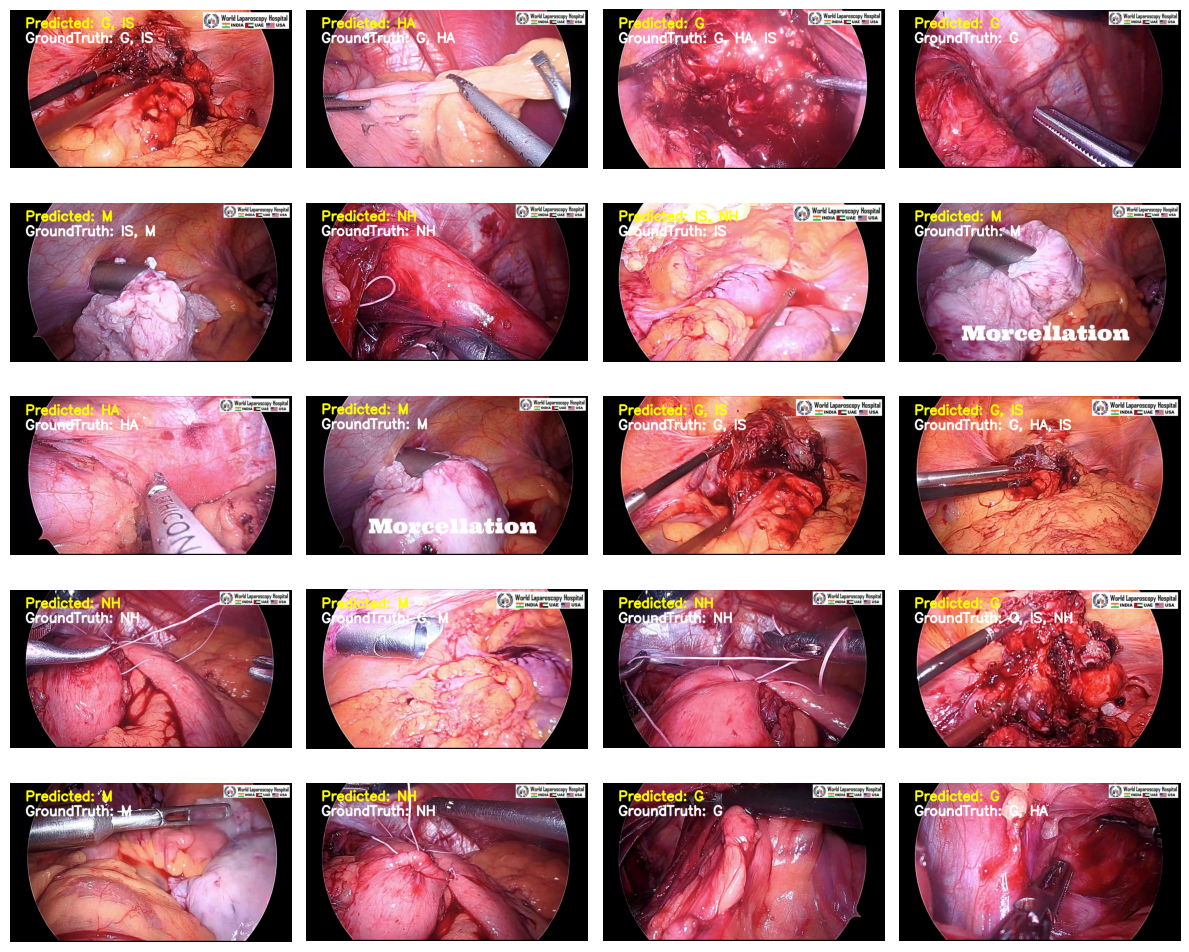

In [47]:
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
    return probs, image

def visualize_predictions(n_images=6, cols=2, best_thresholds_def = [0.5,0.5,0.5,0.5,0.5]):
    from collections import defaultdict
    import random

    # ===== Build a mapping of class_id → image indices (multi-label allowed) =====
    class_to_indices = defaultdict(list)
    for idx, ex in enumerate(val_dataset):
        for class_id, val in enumerate(ex["labels"]):
            if val == 1:
                class_to_indices[class_id].append(idx)

    # ===== Select balanced samples across all classes =====
    selected_indices = set()
    max_per_class = max(1, n_images // len(class_names))
    for class_id, indices in class_to_indices.items():
        random.shuffle(indices)
        count = 0
        for idx in indices:
            if idx not in selected_indices:
                selected_indices.add(idx)
                count += 1
            if count >= max_per_class:
                break

    # Fill up remaining slots (if needed)
    remaining = n_images - len(selected_indices)
    if remaining > 0:
        all_indices = list(set(range(len(val_dataset))) - selected_indices)
        random.shuffle(all_indices)
        selected_indices.update(all_indices[:remaining])

    selected = [val_dataset[i] for i in list(selected_indices)[:n_images]]

    # ======= Your original visualization code =======
    rows = (n_images + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 2))
    axs = axs.flatten()

    for i in range(n_images):
        example = selected[i]
        probs, image = predict(example["image_path"])  # image as np array (H,W,3) RGB

        pred_labels = [class_names[j] for j, p in enumerate(probs) if p > best_thresholds_def[j]]
        true_labels = [class_names[j] for j, v in enumerate(example["labels"]) if v == 1]

        # Convert PIL Image to NumPy array for cv2
        image_np = np.array(image)

        # Convert image from RGB to BGR for cv2
        img_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

        # Define box position and size
        box_x, box_y = 100, 100

        # Text parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 3
        thickness = 12
        line_type = cv2.LINE_AA

        # Predicted labels (yellow)
        pred_text = "Predicted: " + (", ".join(pred_labels) if pred_labels else "None")
        cv2.putText(img_bgr, pred_text, (box_x + 5, box_y + 25), font, font_scale, (0, 255, 255), thickness, line_type)

        # True labels (white)
        true_text = "GroundTruth: " + (", ".join(true_labels) if true_labels else "None")
        cv2.putText(img_bgr, true_text, (box_x + 5, box_y + 125), font, font_scale, (255, 255, 255), thickness, line_type)

        # Convert back to RGB for matplotlib display
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        axs[i].imshow(img_rgb)
        axs[i].axis('off')

    # Hide any unused subplots
    for j in range(n_images, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_predictions(n_images=20, cols=4, best_thresholds_def=best_thresholds)

Class 0 (G):
  Precision: 0.8016
  Recall:    0.8417
  F1 Score:  0.8211

Class 1 (HA):
  Precision: 0.9038
  Recall:    0.7344
  F1 Score:  0.8103

Class 2 (IS):
  Precision: 0.9268
  Recall:    0.7600
  F1 Score:  0.8352

Class 3 (M):
  Precision: 0.9804
  Recall:    0.9804
  F1 Score:  0.9804

Class 4 (NH):
  Precision: 0.9000
  Recall:    0.8438
  F1 Score:  0.8710



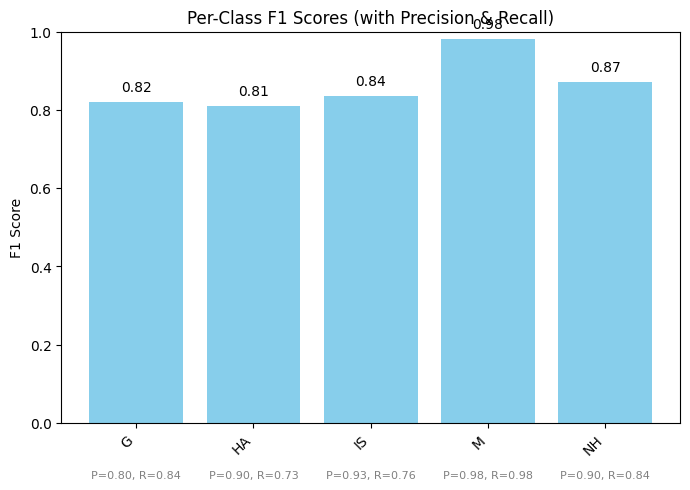

In [40]:
# Apply per-class thresholds
pred_labels_all = (pred_probs_all >= best_thresholds).astype(int)

# === Compute metrics ===
per_class_f1 = f1_score(true_labels_all, pred_labels_all, average=None)
per_class_precision = precision_score(true_labels_all, pred_labels_all, average=None)
per_class_recall = recall_score(true_labels_all, pred_labels_all, average=None)

# === Print per-class metrics ===
for idx, class_name in enumerate(class_names):
    print(f"Class {idx} ({class_name}):")
    print(f"  Precision: {per_class_precision[idx]:.4f}")
    print(f"  Recall:    {per_class_recall[idx]:.4f}")
    print(f"  F1 Score:  {per_class_f1[idx]:.4f}")
    print()

# === Plot F1 Score bar chart with Precision/Recall under bars ===
num_classes = len(class_names)
fig, ax = plt.subplots(figsize=(7, 5))

bars = ax.bar(range(num_classes), per_class_f1, color='skyblue')
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Scores (with Precision & Recall)')

# Annotate bars with F1 on top, and P/R below
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', va='bottom')
    pr_text = f"P={per_class_precision[i]:.2f}, R={per_class_recall[i]:.2f}"
    ax.text(i, -0.12, pr_text, ha='center', va='top', fontsize=8, color='gray')

plt.tight_layout()
plt.show()